In [1]:
#Similar to the price prediction project
#Predicts a trend represented by a best fit line
#Trend is a summary of the next few points

#Still a work in progress

In [2]:
#GETTING MY DATA
import csv
R_Goods = [] #(start, end, name)
R_Vals = []
temp = ""
start = 0
end = 0
i=0
with open('data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        i+=1
        if(row[1]=="Rwanda"):
            if(temp!=row[7]):
                if(temp!=""):
                    end=i
                    R_Goods.append((start,end,temp))
                start = i
                temp = row[7]
            if(row[15]=="100 KG"):
                R_Vals.append(float(row[16])/float(row[12])/100)
            else:
                R_Vals.append(float(row[16])/float(row[12]))

In [3]:
#IMPORTING THE NN STUFF
from liveplot import create_plot
try:
    from jupyterthemes import jtplot
    jtplot.style()
except:
    ImportError
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mynn.activations.relu import relu
from mynn.initializers.glorot_normal import glorot_normal
import mygrad as mg
t = np.linspace(0,41266,41266)

In [4]:
#THE MODEL
#Recurrent neural network
class Model:
    def __init__(self, C,D,K):
        self.dense1 = dense(C,D, weight_initializer=glorot_normal)
        self.dense2 = dense(D,D, weight_initializer=glorot_normal, bias = False)
        self.dense3 = dense(D,K, weight_initializer=glorot_normal)
        self.dim_recurrent = D
    def __call__(self, x):
        h = np.zeros((1,self.dim_recurrent))
        for t in x:
            h = relu(self.dense1(t)+(self.dense2(h)))
        y = self.dense3(h)
        return y
    @property
    def parameters(self):
        #Returns the parameters to back propogate and get the gradient
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters

In [5]:
#PUTTING DATA INTO BATCHES OF CONSISTENT SIZES
x_train = []
y_train = []
x_test = []
y_test = []

R_lens = []
for i in range(len(R_Goods)):
    R_lens.append(R_Goods[i][1]-R_Goods[i][0])
ind = 0
for i in range(len(R_lens)//5*4):
    while(R_lens[i]>=15):
        x_train.append(np.asarray(R_Vals[ind:ind+10]))
        y_train.append(np.asarray(R_Vals[ind+10:ind+15]))
        ind+=15
        R_lens[i]-=15
    ind+=R_lens[i]
    R_lens[i]=0
for i in range(len(R_lens)//5*4,len(R_lens)//5*5):
    while(R_lens[i]>=15):
        x_test.append(np.asarray(R_Vals[ind:ind+10]))
        y_test.append(np.asarray(R_Vals[ind+10:ind+15]))
        ind+=15
        R_lens[i]-=15
    ind+=R_lens[i]
    R_lens[i]=0
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [6]:
print(x_train[0])
print(y_train[0])
print(y_test.shape)

[35.8     37.93334 37.05    37.4     37.24    36.6     40.8     41.85
 45.3     42.64   ]
[43.85 45.5  45.88 48.2  48.5 ]
(982, 5)


In [7]:
#NORMALIZATION
print(x_train[0])
print(y_train[0])
mean = np.mean(x_train)
standev = np.std(x_train)
for i in range(x_train.shape[0]):
    mean = np.mean(x_train[i])
    standev = np.std(x_train[i])
    x_train[i]-=mean
    y_train[i]-=mean
    x_train[i]/=np.sqrt(standev**2+.0000000001)
    y_train[i]/=np.sqrt(standev**2+.0000000001)
print(x_train[0])
print(y_train[0])

[35.8     37.93334 37.05    37.4     37.24    36.6     40.8     41.85
 45.3     42.64   ]
[43.85 45.5  45.88 48.2  48.5 ]
[-1.15238951 -0.44213195 -0.73622427 -0.61969801 -0.67296716 -0.88604376
  0.51227144  0.86185024  2.0104663   1.12486667]
[1.52771462 2.07705274 2.20356697 2.97596965 3.07584931]


In [8]:
#NORMALIZATION
print(x_test[0])
print(y_test[0])


for i in range(x_test.shape[0]):
    mean_test = np.mean(x_test[i])
    standev_test = np.std(x_test[i])
    x_test[i]-=mean_test
    y_test[i]-=mean_test
    x_test[i]/=np.sqrt(standev_test**2+.0000000001)
    y_test[i]/=np.sqrt(standev_test**2+.0000000001)
print(x_test[0])
print(y_test[0])

[2.6969697  3.18181818 3.71515152 3.98484848 4.18181818 3.59090909
 3.03030303 2.8030303  2.42424242 2.85858485]
[3.07575758 2.42424242 3.76767576 4.21969697 4.71969697]
[-0.98203417 -0.11601086  0.83661478  1.31834025  1.67016221  0.61469631
 -0.38664314 -0.79259157 -1.46917228 -0.69336153]
[-0.30545346 -1.46917228  0.93043217  1.73782028  2.63090682]


In [9]:
#bestfit creates the best fit line for an array of 5 numbers
#returns a numpy array of length 2: [slope, y intercept]
def bestfit(arr):
    x_values_temp = np.asarray(list(range(len(arr))))
    x_mean = np.mean(x_values_temp)
    y_mean = np.mean(arr)
    temp = 0
    temp1 = 0
    for i in range(len(arr)):
        temp += (x_values_temp[i]-x_mean)*(arr[i]-y_mean)
        temp1 += (x_values_temp[i]-x_mean)**2
    m=temp/temp1
    b = y_mean - m*x_mean
    return np.asarray([m,b])
#takes the slope and y-intercept and returns 5 points on the line
def y_values(v):
    return np.asarray([v[1],v[1]+v[0],v[1]+v[0]*2,v[1]+v[0]*3,v[1]+v[0]*4])

In [10]:
#takes the best fit lines for the train and test data
best_train = []
for i in range(5578):
    best_train.append(bestfit(y_train[i]))
best_train = np.asarray(best_train)
best_test = []
for i in range(982):
    best_test.append(bestfit(y_test[i]))
best_test = np.asarray(best_test)

<IPython.core.display.Javascript object>


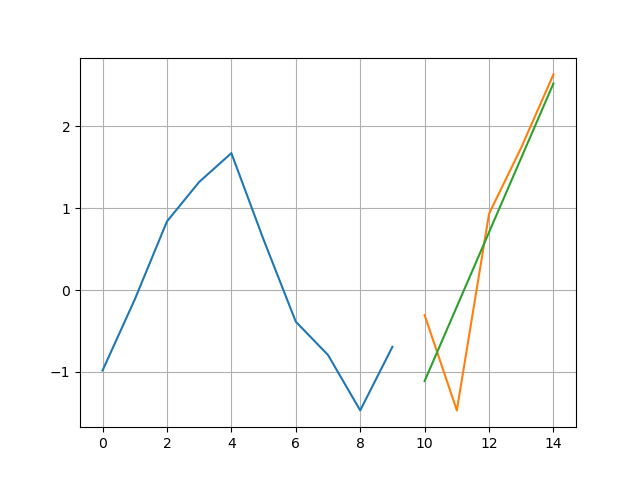

In [11]:
fig, ax = plt.subplots()
ax.plot(t[0:10], x_test[0],marker='')
ax.plot(t[10:15], y_test[0],marker='')
ax.plot(t[10:15], y_values(best_test[0]),marker='')
ax.grid()
#Blue = input points
#Orange = next 5 points in data
#Green = best fit line (output)

In [12]:
from mynn.layers.dense import dense
from mynn.initializers.normal import normal
from mynn.optimizers.adam import Adam
from mynn.losses.cross_entropy import softmax_cross_entropy
#Accuracy is on a scale of -1 to 1
def accuracy(predictions, truth):
    return (predictions[0]*truth[0]+predictions[1]*truth[1])/(np.sqrt(predictions[0]**2+predictions[1]**2)*np.sqrt(truth[0]**2+truth[1]**2)+.0000001)
def l1_loss(pred, true):
    return mg.sum((true - pred)**2) / true.size

In [13]:
mod = Model(10,500,2)
#Adam optimizer
optim = Adam(mod.parameters, learning_rate=.05)

<IPython.core.display.Javascript object>


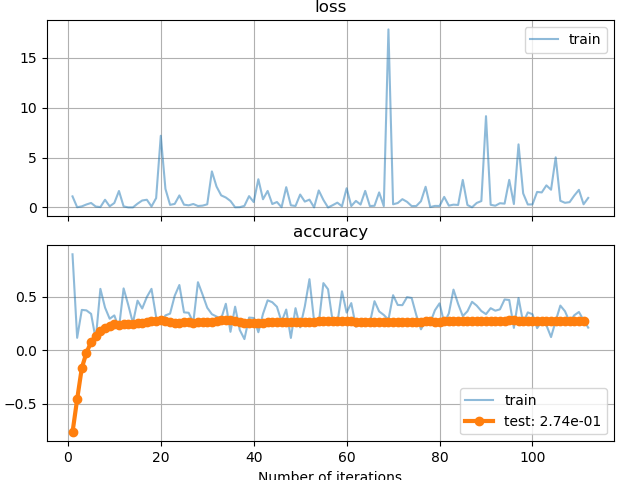

In [14]:
plotter, fig, ax = create_plot(["loss", "accuracy"], refresh=.1);

In [15]:
batch_size = 1
optim = Adam(mod.parameters)
a = []
at = []

x_train = np.asarray(x_train).reshape(5578,1,10)
best_train = np.asarray(best_train).reshape(5578,1,2)
x_test = np.asarray(x_test).reshape(982,1,10)
best_test = np.asarray(best_test).reshape(982,1,2)
for epoch_cnt in range(x_train.shape[0]):
    pred = mod(x_train[epoch_cnt])
    true = best_train[epoch_cnt]
    loss = l1_loss(pred,true)
    acc = accuracy(pred.data[0],true[0])
    loss.backward()
    optim.step()
    loss.null_gradients()
    a.append(acc)
    total_acc = np.mean(a)
    if(epoch_cnt%50==0):
        if(loss.item()>1000):
            plotter.set_train_batch({"loss":1000, "accuracy":total_acc},
                                    batch_size=1, 
                                    plot=True)
        else:
            plotter.set_train_batch({"loss":loss.item(), "accuracy":total_acc},
                                        batch_size=1, 
                                        plot=True)
    if(epoch_cnt%50==0):
        for e in range(50):
            
            acc_test = accuracy(mod(x_test[(epoch_cnt*e)%x_test.shape[0]]).data[0],best_test[(epoch_cnt*e)%best_test.shape[0]][0])
            at.append(acc_test)
            total_test_acc = np.mean(np.asarray(at))
            
            plotter.set_test_batch({"accuracy":total_test_acc},
                                    batch_size=1)
        plotter.plot_test_epoch()
    if(epoch_cnt>50):
        a = a[1:]

<IPython.core.display.Javascript object>


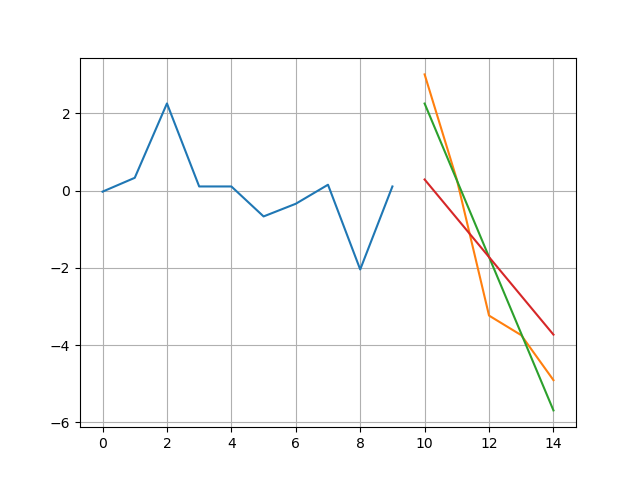

[-0.28923434  0.71531512  1.71986457  2.72441402  3.72896348]


In [16]:
fig, ax = plt.subplots()
row_number = 1
ax.plot(t[0:10], x_test[row_number].reshape(10,),marker='')
ax.plot(t[10:15], y_test[row_number].reshape(5,),marker='')
ax.plot(t[10:15], y_values(best_test[row_number][0]).reshape(5,),marker='')
ax.plot(t[10:15], np.asarray(y_values(mod(x_test[row_number])[0])).astype(float).reshape(5,),marker='')
ax.grid()
print(np.asarray(y_values(mod(x_test[row_number])[0])).astype(float).reshape(5,))

In [17]:
R_Goods = [] #(start, end, name)
temp = ""
start = 0
end = 0
i=0
temp_arr = []
with open('data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        i+=1
        if(row[1]=="Rwanda"):
            if(temp!=row[7]):
                if(temp!=""):
                    end=i
                    R_Goods.append((temp,temp_arr[-10:]))
                    temp_arr=[]
                start = i
                temp = row[7]
            if(row[15]=="100 KG"):
                temp_arr.append((float(row[16])/float(row[12])/100))
            else:
                temp_arr.append(float(row[16])/float(row[12]))

In [18]:
mod(np.asarray([[13.333333333333334, 16.288886666666667, 15.833333333333334, 14.955553333333334, 14.8, 13.333333333333334, 15.911113333333333, 13.333333333333334, 14.444446666666666, 15.555553333333334]]))

Tensor([[ 2.92910745, 16.18422228]])

In [19]:
####################################
#       Trying on stock data       #
####################################
with open("sp500\data_stocks.txt", 'r') as R:
    a = [i for i in R]
data = []
for i in range(1,41267):
    a[i] = a[i][(a[i].index(","))+1:]
    data.append(float(a[i][0:(a[i].index(","))]))
print(len(data))
t = np.linspace(0,41266,41266)
data = np.asarray(data)
print(type(data))

41266
<class 'numpy.ndarray'>


In [20]:
data -= np.mean(data)
data /= np.std(data) / np.mean(R_Vals)
data -= np.min(data)

<IPython.core.display.Javascript object>


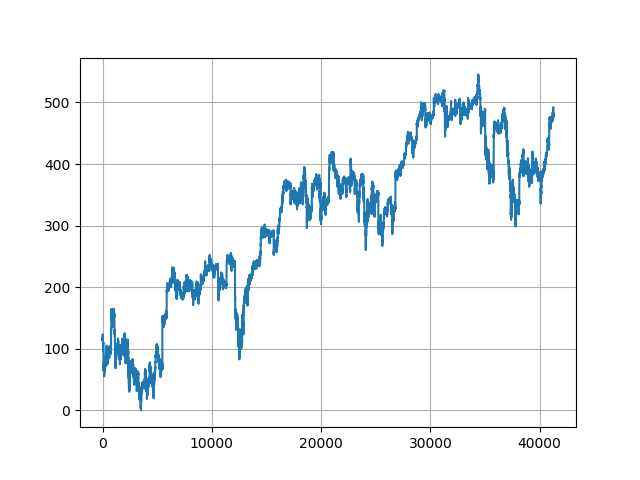

In [21]:
fig, ax = plt.subplots()
ax.plot(t, data,marker='')
ax.grid()

In [22]:
acc = []
i = 0
while(i+15<41266):
    stockmean = np.mean(data[i:i+15])
    stockstv = np.std(data[i:i+15])
    acc.append(accuracy(mod((np.asarray(data[i:i+10]).reshape(1,10)-stockmean)/stockstv).data[0],(data[i+10:i+15]-stockmean)/stockstv))
    i += 1
print(np.mean(np.asarray(acc)))

0.1171104738350394


<IPython.core.display.Javascript object>


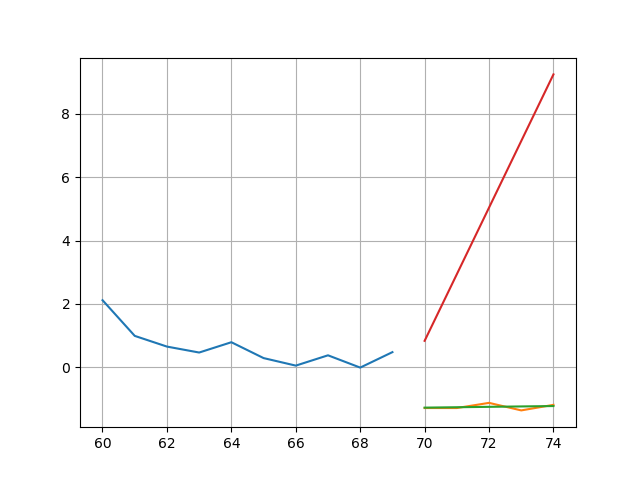

(10,)


In [23]:
fig, ax = plt.subplots()
row_number = 7
stockmean = np.mean(data[row_number*10-10:row_number*10+5])
stockstv = np.std(data[row_number*10-10:row_number*10+5])

ax.plot(t[row_number*10-10:row_number*10], (data[row_number*10-10:row_number*10]-stockmean)/stockstv,marker='')
ax.plot(t[row_number*10:row_number*10+5], (data[row_number*10:row_number*10+5]-stockmean)/stockstv,marker='')
ax.plot(t[row_number*10:row_number*10+5], y_values(bestfit((data[row_number*10:row_number*10+5]-stockmean)/stockstv)),marker='')
print(data[row_number*10-10:row_number*10].shape)
ax.plot(t[row_number*10:row_number*10+5], np.asarray(y_values(mod(((data[row_number*10-10:row_number*10]-stockmean)/stockstv).reshape(1,10))[0]).astype(float).reshape(5,)),marker='')
ax.grid()

In [24]:
acc = []
i = 0
while(i+15<41266):
    stockmean = np.mean(data[i:i+15])
    stockstv = np.std(data[i:i+15])
    acc.append(accuracy(mod((np.asarray(data[i:i+10]).reshape(1,10)-stockmean)/stockstv).data[0],(data[i+10:i+15]-stockmean)/stockstv))
    i += 1
print(np.mean(np.asarray(acc)))

0.1171104738350394
